# Fitting experimental data: 1D mesh


**Attention:** use a kernel from a conda/mamba environment where fenicsx is installed

The fit with the numerical model is relatively slow, because time step size is constant and not (yet) optimized



In [1]:
import sys
import time
import os
import math
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy

Because the ADE_DG toolbox is (probably) not installed somewhere in the system we have to add the path to the location of the python code, either relative path of absolute path.

In [2]:
# import numerical toolbox ADE_DG for solving Advection-Diffusion-Equation specifically for trough-diffusion experiments
#import sys
sys.path.append("../sources") # include path to ../sources/ADE_DG1.py in path! -> this notebook is in ../notebooks/

# ADE_DG1.py must be in the path -> see path settings above
import ADE_DG
from ADE_DG import BoundaryCondition as BoundaryCondition # import BoundaryCondition in this way, otherwise it is not available ...

## Load experimental data

This example uses Magick data, specifically experiment OPC26.

In principle one can load either text files or excel spreadsheets (requires openpyxl) with data. 
Best is to have data available in SI units, all other unit systems are not fail-save!
 * **times** in (s), relative to start of experiment
 * volumetric concentrations  (mol m⁻³) or (Bq m⁻³) or (kg m⁻³) 
 * all other measurements in the same unit system!




In [3]:
%precision %.2e

# load example dataset from Magick data
# define path to data directory
data_path="../../Magick-Data/Through diffusion data _Magic_2025/OPC26/"
data_file_path="Experimental data_OPC26.ods"

# Load data sets from excel file ...sheet name needs to be known...
# we have the first two rows (0 and 1) for header, take first row for name (no.0) and skip second row (no.1)
Cusb=pd.read_excel(data_path+data_file_path,sheet_name='Cusb',header=0,skiprows=[1],engine='odf')
Jdsb=pd.read_excel(data_path+data_file_path,sheet_name='Jdsb',header=0,skiprows=[1])
Makk=pd.read_excel(data_path+data_file_path,sheet_name='Makk',header=0,skiprows=[1])

# next commands remove trailing whitespaces from columns names
# these are a constant source of trouble, 
#because they are not visible if you print them, but are assumed part of column names
Cusb.columns=Cusb.columns.str.strip()
Jdsb.columns=Jdsb.columns.str.strip()
Makk.columns=Makk.columns.str.strip()

# convert to correct units...in the dataset  the times are in Days! 
# (see skipped second row in excel spreadshee)
# 1Day = 1.0*24*3600
Day_to_sec=24.0*3600
Cusb.Time=Cusb.Time*Day_to_sec
Jdsb.Time=Jdsb.Time*Day_to_sec
Makk.Time=Makk.Time*Day_to_sec


In [4]:
print('{:.2e}'.format(Cusb.Cusb[0]))
display(Cusb,Jdsb,Makk)

1.87e-06


,Time,Cusb,U(Cusb),Vhigh
0,0.000000e+00,0.000002,1.185347e-07,19.9634
1,3.443400e+05,0.000002,1.172375e-07,19.9136
2,8.768400e+05,0.000002,1.146135e-07,19.8633
3,1.554240e+06,0.000002,1.161075e-07,19.8128
4,2.156400e+06,0.000002,1.153999e-07,19.7642
5,2.778720e+06,0.000002,1.139443e-07,19.7138
6,3.368340e+06,0.000002,1.150209e-07,19.6634
7,3.978420e+06,0.000002,1.143098e-07,19.6132
8,4.418100e+06,0.000002,1.154624e-07,19.5627
9,5.197200e+06,0.000002,1.127417e-07,19.5116


,Time,JL,U(JL),Vlow
0,4.290000e+04,0.000000e+00,4.307374e-17,10.021
1,1.307400e+05,0.000000e+00,3.997594e-17,9.653
2,2.158800e+05,0.000000e+00,4.955385e-17,9.980
3,3.002100e+05,0.000000e+00,4.464265e-17,9.936
4,4.749300e+05,3.302417e-16,2.926315e-17,9.985
5,6.885300e+05,3.935459e-16,4.126927e-17,9.843
6,8.241900e+05,5.088438e-16,5.816691e-17,9.896
7,1.084740e+06,5.639572e-16,4.190633e-17,9.941
8,1.344150e+06,6.978680e-16,7.189790e-17,9.868
9,1.474950e+06,6.941983e-16,5.871355e-17,9.975


,Time,Accu,U(Accu),Zeit_s,Acum,u(Acum),Acum_m,U(Acum_m)
0,8.580000e+04,0.000000e+00,7.256543e-17,8.580000e+04,0.000000,0.077645,0.000000e+00,7.249768e-17
1,1.756800e+05,0.000000e+00,1.012073e-16,1.756800e+05,0.000000,0.108292,0.000000e+00,1.011128e-16
2,2.560800e+05,0.000000e+00,1.279163e-16,2.560800e+05,0.000000,0.136870,0.000000e+00,1.277968e-16
3,3.443400e+05,0.000000e+00,1.494921e-16,3.443400e+05,0.000000,0.159957,0.000000e+00,1.493525e-16
4,6.055200e+05,1.693564e-15,2.118221e-16,6.055200e+05,1.812114,0.226650,1.691983e-15,2.116243e-16
5,7.715400e+05,2.976443e-15,2.509317e-16,7.715400e+05,3.184794,0.268497,2.973664e-15,2.506974e-16
6,8.768400e+05,4.028509e-15,2.782626e-16,8.768400e+05,4.310504,0.297741,4.024747e-15,2.780028e-16
7,1.292640e+06,8.632776e-15,4.410040e-16,1.292640e+06,9.237070,0.471874,8.624715e-15,4.405923e-16
8,1.395660e+06,1.004442e-14,4.643660e-16,1.395660e+06,10.747527,0.496872,1.003504e-14,4.639324e-16
9,1.554240e+06,1.220595e-14,4.990570e-16,1.554240e+06,13.060368,0.533991,1.219455e-14,4.985910e-16


In the next cell we have to insert some values for the diffusion cell:

The values are used (partly) for calculations, therefore units need to follwo SI..
Here I made a screenshot from spreadsheet for OPC26
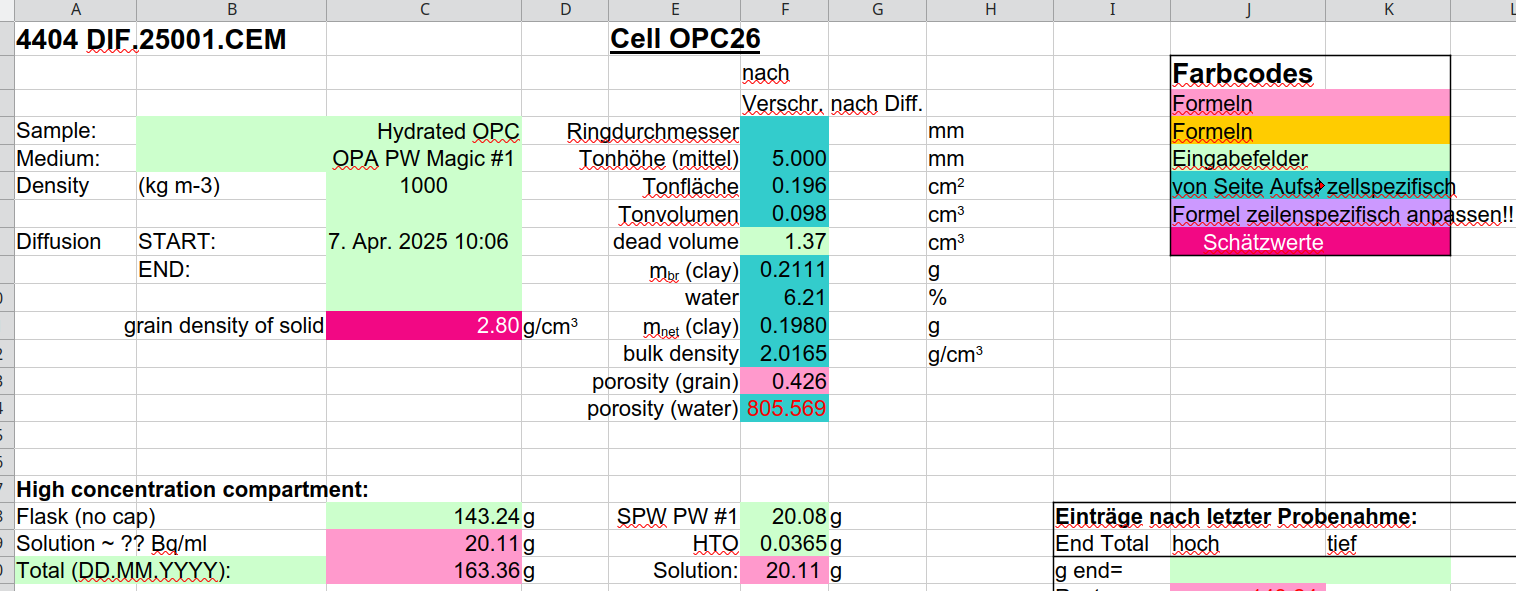
and here the right side with some uncertainties for measurements
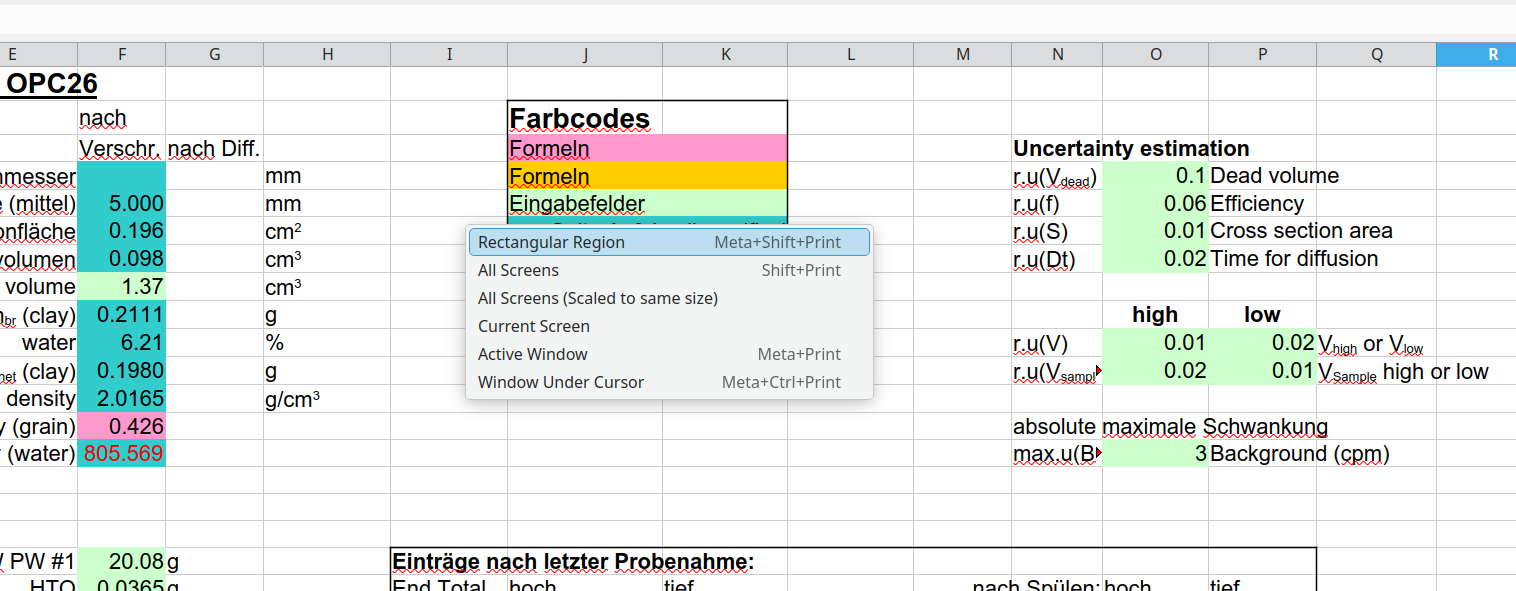

Experiment was conducted at 40°C
Temperature influence on reservoir volumes was not considered for estimation of experimental results..
Dead volume (missing filters) was not considered for reservoir volumes!



In [5]:
#sample thickness
sample_thickness=5e-3 # unit (m) = 5 mm
cross_section_area = 0.196e-4 # unit (m²) 0.196 cm * cm
# first attempt: we start with constant reservoir volumes
upstream_volume=Cusb.Vhigh[0]
downstream_volume=Jdsb.Vlow[0]
upstream_concentration=Cusb['Cusb'][0]
downstream_concentration=0.0

# select fitting parameter for breakthrough
tdat=Jdsb.Time[0:20]
fdat=Jdsb.JL[0:20]

## Create and initialize function for numerical solver

One has to initialize and create a function that can be called from the fitting routine. 

The basic setup is based on mesh that was created with gmsh:

    * The dimensions of the mesh should be choosen that they represent the dimensions of the diffusion cell, filters, sample.
    * The different materials (sample, filter) and the influx (upstream) and outflux (downstream) boundaries have to be marked with "physical group Ids"
    * It is assumed the the upstream boundary is at x=0m and the downstream boundary at x = "lenght of sample + filters" in positive x-direction

The numerical solver is initialized via the ADE_DG call that reads the mesh from a file and requires a parameter that sets the "degree" of DG elements.

For the numerical setup the follwing parameters have to be defined and passed to the code:

    * material parameters
        - De and porosity/alpha for all materials (filter,sample)
        - Cross sectional area of the sample/filters
    * initial conditions
       - Initial concentrations everywhere in the domain
    * boundary conditions
        - position of the boundaries and their physical group id (marker no.)
        - initial concentrations in the Upstream and Downstream reservoirs
        - volume of the reservoirs
        - A flag that sets constant (boundary) concentrations in the reservoir: set_reservoir_boundaries(False), 
        or adjusts reservoir concentrations according to fluxes out of or into the reservoir: set_reservoir_boundaries(True)
        


In [6]:
# general definitions    
hour=3600.0
day=hour*24.0
year=day*365.25

# filename for gmsh file
mymesh_filename = "./gmsh/Magick.msh"
# define problem
# degree of desired FE is moved into ADE_DG
problem = ADE_DG.ADE_DG(mymesh_filename,deg=2)

# define everything once

# initial conditions
C0=0.0 # initial condition

# effective Diffusion for all marked materials
# we introduce default values
# markers can be found in gmsh geo file
De=1.0e-11
De_dict={
    7 : 1.0e-11,   #sample
}

# porosity/alpha ..this are default values
alpha=0.1
porosity_dict={
    7 : alpha    #sample
}
# if diffusion only the Darcy flux is 0.0 (zero) for all components
darcy_flux_vector = (0.0,0.0) # list  will work ...

# initial condition
C0=0.0
problem.set_initial_conditions(C0)

problem.set_darcy_flux(darcy_flux_vector)
problem.set_De(De_dict)
problem.set_porosity(porosity_dict)
# write materials in specific vtx file (do not use the same file as for time steps. this will overwrite file=
#problem.vtx_write_materials(filename_vtx_materials,t=0.0) 
problem.set_upstream_boundary(5,0.0) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration) # will be overwritten in flux_model function
problem.set_upstream_reservoir_volume(upstream_volume)
problem.set_downstream_boundary(6,0.005) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0) # will be overwritten in flux_model function
problem.set_downstream_reservoir_volume(downstream_volume)
problem.set_downstream_reservoir_exchange_solution_times(tdat) # needs to be done, even if update_reservoir_boundaries(False) is set!
problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
problem.set_cross_section_area(cross_section_area) # 1 for comparison with analytical solution

INFO:root:INFO: init with: ./gmsh/Magick.msh deg 2
INFO:root:INFO: mesh read! mesh dimension: 2 boundary dimension 1 geometry dimension: 2
INFO:root:Darcy flux is set to: (0.0, 0.0) for the whole domain.
INFO:root:INFO: De set via dictionary {7: 1e-11} default: 1.0e-11 
INFO:root:porosity set via dictionary {7: 0.1} default: 1.0


Info    : Reading './gmsh/Magick.msh'...
Info    : 9 entities
Info    : 36 nodes
Info    : 36 elements
Info    : Done reading './gmsh/Magick.msh'


In [7]:
def flux_model(t,alpha,De):
    # t is log space -> set to real space
    t_real= t #np.pow(t,10.0)
    
    #### definitions for ADE-DG solutions that need to be re-set for multiple runs
    # only reset everything that is changed during simulations or due to call -> alpha
    C0=0.0 # initial concentration 
    
    # porosity
    porosity_dict={
        7 : alpha  #sample
    }
    De_dict={
        7 : De,   #sample
    }
    u_old=problem.set_initial_conditions(C0)
    u_new=copy(u_old) # make a copy for u_new

    problem.set_porosity(porosity_dict)
    problem.set_De(De_dict)

    #problem.set_upstream_boundary(5,0.0) # should be "left boundary"
    problem.set_upstream_reservoir_concentration(upstream_concentration)
    
    #problem.set_downstream_boundary(6,0.005) # should be "right  boundary"
    problem.set_downstream_reservoir_concentration(0.0)
    
    problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
    
    # Time stepping
    t_end=max(t)
    dt=1000.0
    problem.set_dt(dt)
    problem.set_T_end(t_end)
    #problem.set_tol_adaptive(1.0e-6)
    #problem.set_dtmax=(t_end/10)
    #problem.set_vtx_filename(filename_vtx, 10)
    
    solution,data=problem.solve_adaptive_timesteps()
    
    #solution,data=problem.solve_timesteps() # solution is fenics Function(V) object, while data is a pandas data frame


    # for time interpolation we can use np.interpolate
    flux=np.interp(t_real, data.time, np.abs(data.Downstream_flux)) 
    #print("Debug flux_model: called with alpha,De",alpha,De)
    #print("Debug: solution, data, flux ",solution,data,flux)
    return (flux) 

## One manual run to test parameters

Before one does possibly time consuming fitting, it makes sense to once run the model to check input parameters and if the model runs at all.



In [8]:
t_real= max(tdat) #np.pow(t,10.0)

#### definitions for ADE-DG solutions that need to be re-set for multiple runs
# only reset everything that is changed during simulations or due to call -> alpha
C0=0.0 # initial concentration 

# porosity
porosity_dict={
    7 : 0.637  #sample
}
De_dict={
    7 : 2.47e-12,   #sample
}
u_old=problem.set_initial_conditions(C0)
u_new=copy(u_old) # make a copy for u_new

problem.set_porosity(porosity_dict)
problem.set_De(De_dict)

#problem.set_upstream_boundary(5,0.0) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration)

#problem.set_downstream_boundary(6,0.005) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0)

problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties

# Time stepping
t_end=max(tdat)
dt=1000.0
problem.set_dt(dt)
problem.set_T_end(t_end)
#problem.set_tol_adaptive(1.0e-6)
#problem.set_dtmax=(t_end/10)
#problem.set_vtx_filename(filename_vtx, 10)

solution,data=problem.solve_adaptive_timesteps()
#solution,data=problem.solve_timesteps() # solution is fenics Function(V) object, while data is a pandas data frame

INFO:root:porosity set via dictionary {7: 0.637} default: 1.0
INFO:root:INFO: De set via dictionary {7: 2.47e-12} default: 1.0e-11 
INFO:root:INFO: Adaptive time loop starts with error tolerance: 0.001 update_reservoir_concentrations: False
INFO:root:INFO: t dt error est     0.0000 |  1000.0000 |  1.932e-11
INFO:root:INFO: t dt error est  1000.0000 | 41900.0000 |  1.143e-10
INFO:root:INFO: t dt error est 42900.0000 | 87840.0000 |  5.457e-11
INFO:root:INFO: t dt error est 130740.0000 |     0.0000 |  2.563e-25
INFO:root:INFO: t dt error est 130740.0000 |     0.8624 |  3.943e-18
INFO:root:INFO: t dt error est 130740.8624 | 85139.1376 |  3.941e-11
INFO:root:INFO: t dt error est 215880.0000 | 84330.0000 |  3.034e-11
INFO:root:INFO: t dt error est 300210.0000 | 174720.0000 |  2.595e-11
INFO:root:INFO: t dt error est 474930.0000 | 213600.0000 |  2.369e-11
INFO:root:INFO: t dt error est 688530.0000 | 135660.0000 |  2.132e-11
INFO:root:INFO: t dt error est 824190.0000 | 260550.0000 |  1.965e-11

In [9]:
display(data)
test=np.interp(tdat, data.time, np.abs(data.Downstream_flux))
display(test)

,time,dt,Upstream_concentration,Downstream_concentration,Upstream_flux,Downstream_flux
row1,0.000000e+00,1.000000e+03,0.000002,0.0,4.454255e-14,4.125835e-41
row1,1.000000e+03,4.190000e+04,0.000002,0.0,1.686990e-14,-3.475219e-23
row1,4.290000e+04,8.784000e+04,0.000002,0.0,1.117141e-14,-1.992373e-19
row1,1.307400e+05,1.455192e-11,0.000002,0.0,1.117141e-14,-1.992373e-19
row1,1.307400e+05,8.623694e-01,0.000002,0.0,1.118230e-14,-1.992437e-19
row1,1.307409e+05,8.513914e+04,0.000002,0.0,8.347455e-15,-3.829437e-18
row1,2.158800e+05,8.433000e+04,0.000002,0.0,6.504869e-15,-2.184095e-17
row1,3.002100e+05,1.747200e+05,0.000002,0.0,5.480645e-15,-1.254253e-16
row1,4.749300e+05,2.136000e+05,0.000002,0.0,4.779958e-15,-3.039685e-16
row1,6.885300e+05,1.356600e+05,0.000002,0.0,4.134441e-15,-4.105351e-16


array([1.99237264e-19, 1.99243713e-19, 2.18409479e-17, 1.25425291e-16,
       3.03968455e-16, 4.10535060e-16, 5.74287409e-16, 6.87923000e-16,
       7.30480669e-16, 7.83034952e-16, 8.22631818e-16, 8.45932844e-16,
       8.67500430e-16, 8.83786795e-16, 8.93330146e-16, 9.01375866e-16,
       9.07351985e-16, 9.11028699e-16, 9.14391109e-16, 9.14391109e-16])

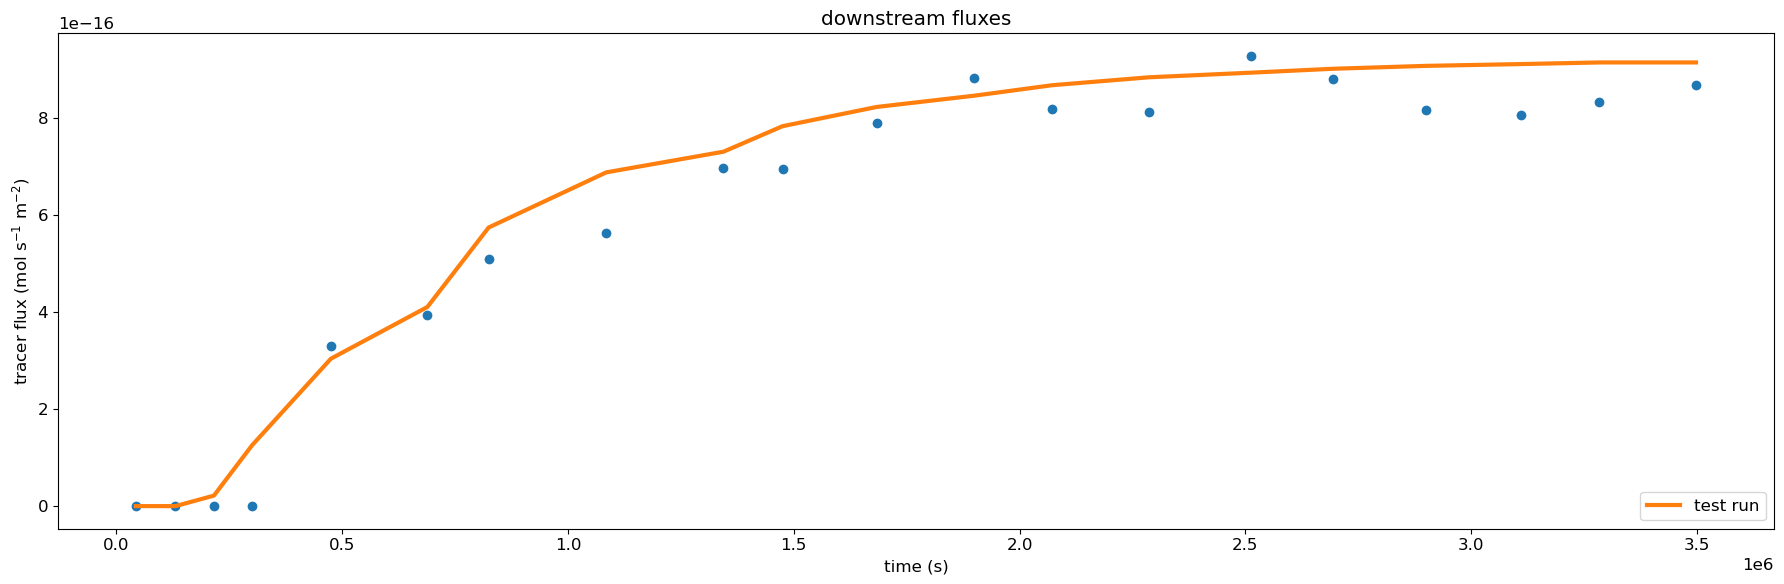

In [11]:
# firs we plot the fluxes ...aka breakthrough

plt.rcParams["figure.figsize"] = [18, 6]

plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
#display(fluxes)

plt.rcParams.update({'font.size': 12}) # update font size..default is 10 !

plt.plot(tdat, fdat, 'o')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
plt.plot(tdat, test, '-', label='test run')

plt.title('downstream fluxes')
plt.xlabel('time (s)')
plt.ylabel(r'tracer flux (mol s$^{-1}$ m$^{-2}$)')

plt.legend(facecolor='white', loc='lower right')
plt.tight_layout()
plt.show()

## Fitting with LMFIT

https://lmfit.github.io/lmfit-py/intro.html

The lmfit package provides simple tools to help you build complex fitting models for non-linear least-squares problems and apply these models to real data.

**Install lmfit-py with** **"mamba install lmfit"**

Why use lmfit?

While scipy offers an standard approach to optimization and curve fitting, LMFIT is a specialised tool that offers better support for advanced methods and diagnostic tools!


In [12]:

import lmfit as lmfit

#params = lmfit.Parameters()
#params.add('alpha', 0.6) # starting value for fit
#params.add('De', value=3.0e-12) # starting value for fit


In [13]:
problem.set_logging_level("ERROR") # This gives only information in case of errors 

ademodel=lmfit.Model(flux_model)
print(f'parameter names: {ademodel.param_names}')
print(f'independent variables: {ademodel.independent_vars}')

result_ademodel=ademodel.fit(fdat, t=tdat, alpha=0.3,De=3.0e-12)


print(result_ademodel.fit_report())


set logging to level:  ERROR
parameter names: ['alpha', 'De']
independent variables: ['t']
[[Model]]
    Model(flux_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 20
    # variables        = 2
    chi-square         = 4.5586e-32
    reduced chi-square = 2.5326e-33
    Akaike info crit   = -1499.22882
    Bayesian info crit = -1497.23736
    R-squared          = 1.00000000
[[Variables]]
    alpha:  0.63265447 +/- 0.04240842 (6.70%) (init = 0.3)
    De:     2.3491e-12 +/- 5.3263e-14 (2.27%) (init = 3e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, De) = +0.8338


In [14]:
dely = result_ademodel.eval_uncertainty(sigma=3)

#plt.fill_between(x, result.best_fit-dely, result.best_fit+dely, color="#ABABAB",
#                 label=r'3-$\sigma$ uncertainty band')

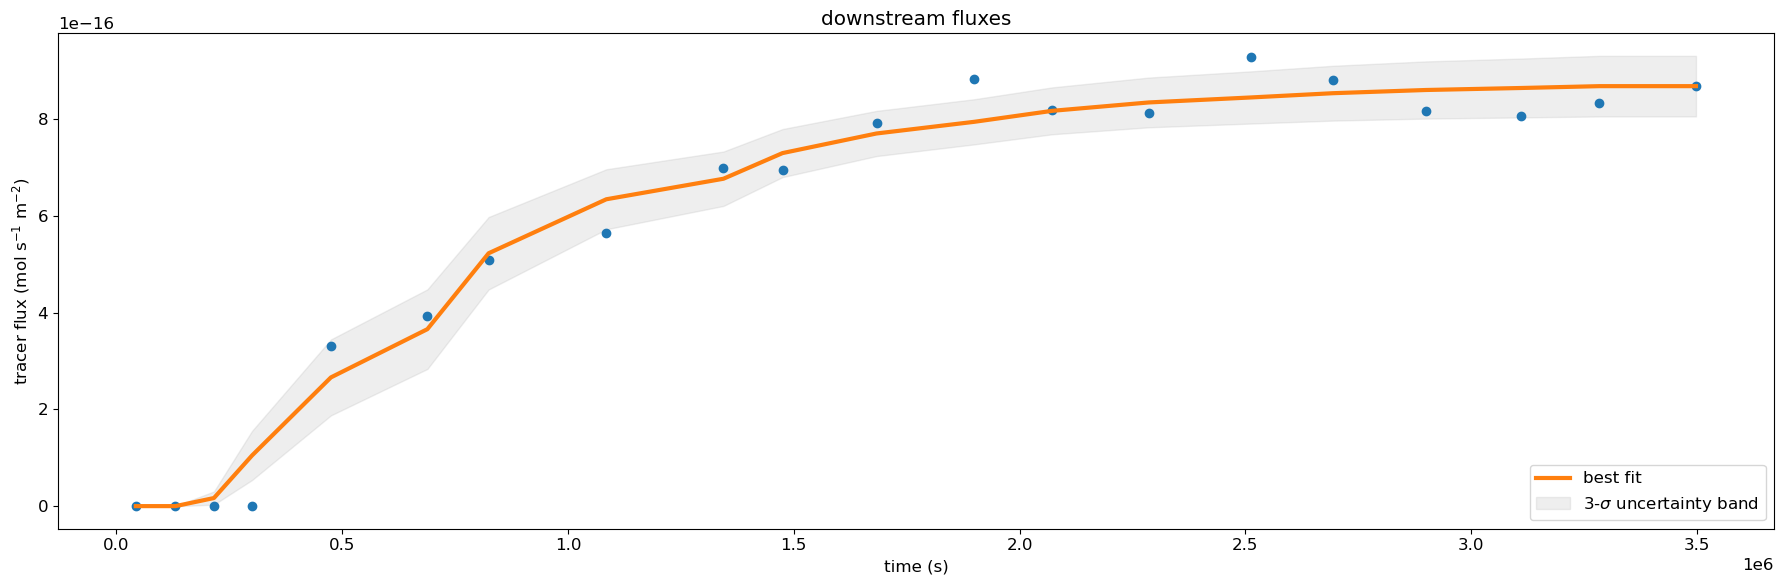

In [15]:
# firs we plot the fluxes ...aka breakthrough
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
#display(fluxes)

plt.rcParams.update({'font.size': 12}) # update font size..default is 10 !

plt.plot(tdat, fdat, 'o')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
plt.plot(tdat, result_ademodel.best_fit, '-', label='best fit')
plt.fill_between(tdat, result_ademodel.best_fit-dely, result_ademodel.best_fit+dely, color="#ABABAB",
                 label=r'3-$\sigma$ uncertainty band',alpha=0.2)

plt.legend()
plt.title('downstream fluxes')
plt.xlabel('time (s)')
plt.ylabel(r'tracer flux (mol s$^{-1}$ m$^{-2}$)')

plt.legend(facecolor='white', loc='lower right')
plt.tight_layout()
plt.show()

In [16]:
result_ademodel.best_fit

array([1.37128721e-19, 1.37133678e-19, 1.68302933e-17, 1.04692415e-16,
       2.65985019e-16, 3.65632958e-16, 5.22424245e-16, 6.33896939e-16,
       6.76306635e-16, 7.29286904e-16, 7.69782488e-16, 7.93927325e-16,
       8.16556885e-16, 8.33892250e-16, 8.44188892e-16, 8.52979151e-16,
       8.59597456e-16, 8.63721348e-16, 8.67540021e-16, 8.67540021e-16])